# Pairs Trading Algorithm Project

## <b>Overview</b>

- Pairs trading is a statistical arbitrage form of trading based on mean reversion and mathematical analysis.
- It is a strategy where we look to find a highly correlated and stationary pair of securities (ie: 0.9 correlation).
- The goal is to be long Security A, and short Security B such that you maximize the return on both assets reverting to their means, while eliminating your exposure to Delta Risk.
     - The aim of pairs trading is to bet that, if the prices of 2 assets diverge, they will converge eventually.

- Here is a diagram of the basic concept of pairs trading, notice that the return on the trade is the spread capitalization - transaction cost .

![PairsTradingDiagram.png](PairsTradingDiagram.png)


1.<b>Method:</b>
1. We aim to create a model which tests for correlation between the basket of securities for stationary pairs.
2. We then test for cointegration, which is a test between two time series to whether they will deviate approximating a relative mean.
    - To do so, we can use the <b>Engle–Granger</b> two-step method to test for cointegration.
    - We can also use the <b>Johansen</b> test to check for cointegration between the two time series.
3. We also need to test for stationarity of the time series, whether the time series have variances or means which changes over time.
    - Examples of these could be stochastic processes such as random walk time series, or trend/cycle time series.
    - We can test for stationarity using the <b>Augmented Dickey-Fuller Test</b>.


1.1 <b>Cointegration:</b>

What is cointegration?
By definition, cointegration is a technique used to find a possible correlation between time series processes in the long term which does not rely on linear regression. Is a phenomenon observed in a time series context. Several time series cointegrate if there exists a linear combination that is integrated of a lower order than the series themselves. Different to linear regression (OLS method), cointegration is able to observe relationships and trends in time series and figure out whether the whether the spread between two instruments is stationary. This is effective in a pairs trade, because we want to determine whether the spread between the assets stay the same, or will vary or trend a specific way. Since correlation only signifies whether two assets move in similar directions, it is not a good metric to evaluate whenther a pairs trade would be effective for the security, hence, it is important to test for cointegration. We will show case a real world example of this later on, where two securities may be perfectly correlated, but unable to pass the cointegration test.

2.<b>Imports</b>

In [5]:
from statistics import mean
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from hurst import compute_Hc
import math
import seaborn as sn
from matplotlib.pyplot import figure
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
import numpy as np

Tool Utilization:
- Pandas (Data Manipulation)
- yFinance(Pulling Data Points)
- Stats Models
- Hurst
- Date Time
- Seaborn (Heat Maps)
- Numpy
- Matplotlib

<b>Trading Method:</b>
- Find 2 assets from S&P500 that move similarly with eachother (whether it be a negative or positive correlation or cointegration)
- Trade the spread tightening (mean-reversion) between the two correlated securities by being long Security A and Short Security B

<b>Cointegration Sample:</b>

Lets try to generate some fake securities to test for some cointegration
- We can set the seed for the python plot 
- We then generate a random security (Security A) while drawing samples from a normal distribution, the time series will be shifted up to mimic a traded security

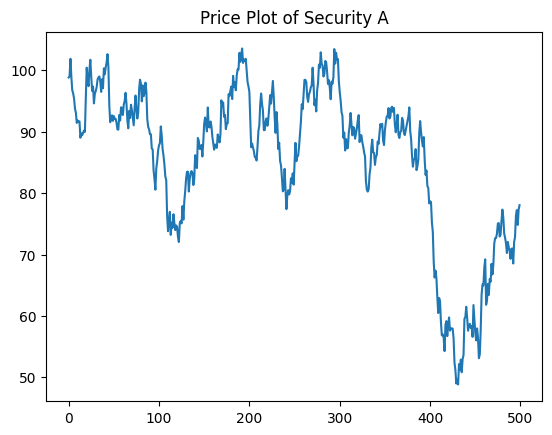

In [6]:
np.random.seed(591)
samples_a = np.random.normal(0, 2, 500) # Generate return for 500 samples (Mu = 0, Sigma = 0.1, Scale = 500)
#Shift to price range and plot
SecA = 100 + pd.Series(np.cumsum(samples_a), name='Security A')
SecA.plot(title= "Price Plot of Security A");


Next, we generate a security B to visualize against Security A. 

Since our goal is to demonstrate securities which are cointegrated, we can generate a security B which has a significant fundemental correlation to security A, while adding additional randomness/noise to the data. We can do so by adding additional data from a normal distribution to the data of Security A. 

Security B will also be priced at a different level than Security A, for the sake of capturing the resemblance to how correlated securities can be priced in the market.

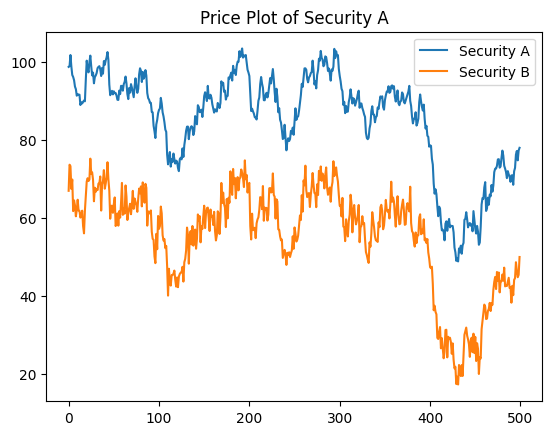

In [7]:
SecB = np.random.normal(0, 2, 500) + SecA - 30 #Generate random noise and Price Sec B $30 less than A
#Note that this random noise is drawn from a normal distribution and is not affected by the seed set earlier
SecB.name = 'Security B'
pd.concat([SecA, SecB], axis=1).plot(title= "Price Plot of Security A and B");

The two time series are generated with the same model, with varying pattern in noise as well as a shift. In this case, the two time series are cointegrated. Unlike correlation, note that cointegration is not neccesarily distinguishable visibly, we will show an example of this later.

We can now visually test for cointegration by plotting the spread function between the two generated securities.



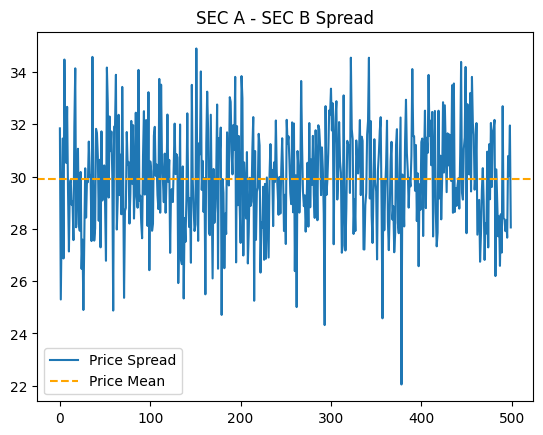

In [48]:
#Plotting spread
plt.plot(SecA - SecB, label = 'Spread(Sec A - Sec B)')
#We do not plot median since mean appears to be identical to median
plt.axhline((SecA - SecB).mean(), linestyle = '--', color = 'orange')
plt.title("SEC A - SEC B Spread")
plt.legend(["Price Spread", "Price Mean"]);

Here, we can visually examine that the spread follows a stationary trend, as can be show with the "Price mean" orange line. We can examine that the spread of the security prices remains consistent and deviates around 30. Logically, this passes our sanity check, since we shifted Security B down by 30, while adding on noise drawn from a normal distribution. We can now take a look at the price ratio of the two securities.

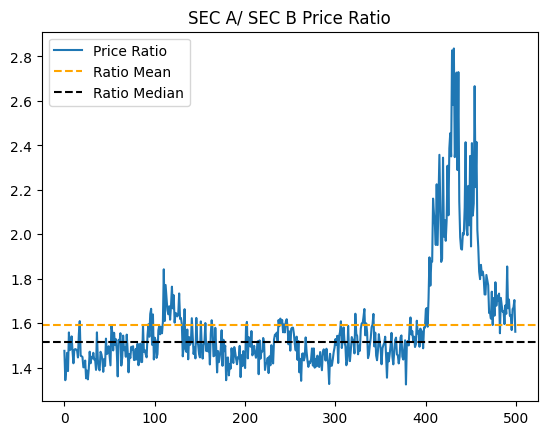

In [54]:
ratio_series = SecA/SecB
plt.plot(ratio_series, label = 'SEC A/ SEC B Price Ratio')
plt.axhline(ratio_series.mean(), linestyle = '--', color='orange')
plt.axhline(ratio_series.median(), linestyle = '--', color='black')
plt.legend(["Price Ratio", "Ratio Mean", "Ratio Median"])
plt.title("SEC A/ SEC B Price Ratio");

Find pair in s&p500 by iterating

1.0


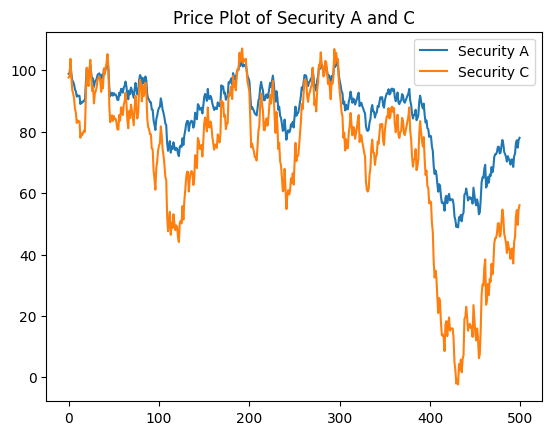

In [55]:

SecC = 100 + pd.Series(np.cumsum(samples_a*2), name='Security C')

pd.concat([SecA, SecC], axis=1).plot(title= "Price Plot of Security A and C");

corr_ac = SecA.corr(SecC)

print (corr_ac)